In [1]:
from datasets import load_dataset
import numpy as np
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, accuracy_score
from huggingface_hub import login

# --- Dataset Loading and Preprocessing ---
# Load the dataset
dataset = load_dataset("google-research-datasets/go_emotions")

# Define the label mapping (unchanged)
label_mapping = {
    'admiration': 'admiration',
    'amusement': 'amusement',
    'anger': 'anger',
    'annoyance': 'annoyance',
    'approval': 'approval',
    'caring': 'caring',
    'confusion': 'confusion',
    'curiosity': 'curiosity',
    'desire': 'desire',
    'disappointment': 'disappointment',
    'disapproval': 'disapproval',
    'disgust': 'disgust',
    'embarrassment': 'embarrassment',
    'excitement': 'excitement',
    'fear': 'fear',
    'gratitude': 'gratitude',
    'grief': 'grief',
    'joy': 'joy',
    'love': 'love',
    'nervousness': 'nervousness',
    'neutral': 'neutral',
    'optimism': 'optimism',
    'pride': 'pride',
    'realization': 'realization',
    'relief': 'relief',
    'remorse': 'remorse',
    'sadness': 'sadness',
    'surprise': 'surprise'
}

# Get target categories
target_categories = sorted(set(label_mapping.values()))
id2label = {i: label for i, label in enumerate(target_categories)}
label2id = {label: i for i, label in id2label.items()}

# --- Fixed Label Mapping Function ---
def map_labels(example):
    mapped_labels = {category: 0.0 for category in target_categories}
    # Correctly iterate over label indices
    for label_idx in example['labels']:
        original_label = dataset['train'].features['labels'].feature.names[label_idx]
        mapped_label = label_mapping[original_label]
        mapped_labels[mapped_label] = 1.0
    example['mapped_labels'] = [mapped_labels[category] for category in target_categories]
    return example

# Apply label mapping
dataset = dataset.map(map_labels)

# --- Class Weight Calculation ---
train_labels = np.array(dataset['train']['mapped_labels'])
positive_samples = train_labels.sum(axis=0)
total_samples = len(train_labels)
negative_samples = total_samples - positive_samples
pos_weight = torch.tensor(negative_samples / positive_samples, dtype=torch.float)
pos_weight = torch.clamp(pos_weight, min=1e-6)

# --- Tokenization ---
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Prepare datasets
for split in tokenized_datasets:
    tokenized_datasets[split] = tokenized_datasets[split].remove_columns(["labels"])
    tokenized_datasets[split] = tokenized_datasets[split].rename_column("mapped_labels", "labels")

columns_to_keep = ["input_ids", "token_type_ids", "attention_mask", "labels"]
tokenized_datasets = tokenized_datasets.remove_columns(
    [col for col in tokenized_datasets["train"].column_names if col not in columns_to_keep]
)

# --- Initialize BERT model ---
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(target_categories),
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)

# Add dropout to classifier
class BertClassifierWithDropout(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert = bert_model.bert
        self.dropout1 = nn.Dropout(0.5)
        self.intermediate = nn.Linear(bert_model.config.hidden_size, bert_model.config.hidden_size)
        self.activation = nn.GELU()
        self.dropout2 = nn.Dropout(0.5)
        self.classifier = nn.Linear(bert_model.config.hidden_size, bert_model.config.num_labels)
        
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, 
                head_mask=None, inputs_embeds=None, output_attentions=None, output_hidden_states=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states
        )
        
        pooled_output = outputs[1]  # CLS token
        x = self.dropout1(pooled_output)
        x = self.intermediate(x)
        x = self.activation(x)
        x = self.dropout2(x)
        logits = self.classifier(x)
        
        return logits

# Create a custom BERT model with dropout
bert_base = model
bert_with_dropout = BertClassifierWithDropout(bert_base)

# --- Custom Trainer Class with Fixed Method Signature ---
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Modified to accept **kwargs which includes num_items_in_batch
        labels = inputs.pop("labels")
        
        # Forward pass
        if isinstance(model, BertClassifierWithDropout):
            logits = model(**inputs)
        else:
            outputs = model(**inputs)
            logits = outputs.logits
            
        # Loss calculation
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        
        if return_outputs:
            return loss, {"logits": logits}
        return loss
    
    def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None):
        with torch.no_grad():
            # Get inputs
            has_labels = "labels" in inputs
            inputs = self._prepare_inputs(inputs)
            labels = inputs.pop("labels") if has_labels else None
            
            # Forward pass
            if isinstance(model, BertClassifierWithDropout):
                logits = model(**inputs)
            else:
                outputs = model(**inputs)
                logits = outputs.logits
                
            # Loss calculation if labels are provided
            loss = None
            if has_labels:
                loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(logits.device))
                loss = loss_fct(logits, labels)
                
            return loss, logits, labels

# --- Training Arguments ---
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.03,  # Increased from 0.01
    load_best_model_at_end=True,
    metric_for_best_model="val_loss",  # Changed to use val_loss as metric
    greater_is_better=False,  # Lower loss is better
    logging_dir='./logs',
    logging_steps=10,
    push_to_hub=True,
    hub_model_id="emotion-classifier",
)

# --- Metrics Calculation ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)
    
    # Calculate F1 scores
    micro_f1 = f1_score(labels, predictions, average='micro')
    macro_f1 = f1_score(labels, predictions, average='macro')
    
    # Calculate accuracy - considering a prediction correct if all labels match
    accuracy = accuracy_score(labels.flatten(), predictions.flatten())
    
    # Calculate validation loss manually
    loss_fct = nn.BCEWithLogitsLoss()
    val_loss = loss_fct(torch.tensor(logits), torch.tensor(labels, dtype=torch.float)).item()
    
    return {
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "accuracy": accuracy,
        "val_loss": val_loss
    }

# --- Training with Early Stopping ---
trainer = CustomTrainer(
    model=model,  # Use the standard model since we're having issues with the custom model
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)

# Start training
trainer.train()

# Evaluate the model on the test set
test_results = trainer.evaluate(tokenized_datasets["test"])
print(f"Test Results: {test_results}")

# Save the best model
trainer.save_model("./best_model")

C:\Users\ws-\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ws-\AppData\Roaming\Python\Python312\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Accuracy,Val Loss,Runtime,Samples Per Second,Steps Per Second
1,0.588700,0.665524,0.369063,0.322605,0.880904,0.308652,24.049800,225.616000,14.137000
2,0.480700,0.645448,0.410718,0.369835,0.900841,0.255693,22.039700,246.192000,15.427000
3,0.590100,0.636672,0.419864,0.374755,0.905962,0.244945,22.805500,237.926000,14.909000
4,0.300500,0.722784,0.466326,0.410086,0.924372,0.201192,22.847000,237.493000,14.882000
5,0.281000,0.779956,0.479022,0.425861,0.929302,0.188906,21.222800,255.668000,16.020000


Test Results: {'eval_loss': 0.7629826664924622, 'eval_micro_f1': 0.47431746798743657, 'eval_macro_f1': 0.4187456894691755, 'eval_accuracy': 0.9284069072626286, 'eval_val_loss': 0.19107629358768463, 'eval_runtime': 18.4829, 'eval_samples_per_second': 293.623, 'eval_steps_per_second': 18.395, 'epoch': 5.0}


In [6]:
def predict_emotion(text, threshold=0.1):
    # Ensure model is on the right device
    device = model.device
    
    # Tokenize and move to device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]
    
    # Get labels with probability > threshold
    predicted_labels = [(target_categories[i], prob) 
                       for i, prob in enumerate(probs) if prob > threshold]
    
    # Sort by probability descending
    predicted_labels.sort(key=lambda x: x[1], reverse=True)
    
    # Fallback to top 3 if no labels above threshold
    if not predicted_labels:
        top_indices = np.argsort(probs)[-3:][::-1]
        predicted_labels = [(target_categories[i], probs[i]) for i in top_indices]
    
    return [label for label, _ in predicted_labels], probs

In [28]:
# Load model and tokenizer (ensure this runs first)
# model_name = "stl25338/e-classifier"  # Your model name
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

print("\nEMOTION CLASSIFIER DEMO")
print("=======================")

test_texts = [
    "I want to kill myself, I can't take this pain anymore.",
    "I love this song, it's so uplifting!", 
    "I'm feeling really sad today.",
    "I can't believe how beautiful this place is.",
    "I'm so angry at the way they treated me."
]

for i, text in enumerate(test_texts, 1):
    print(f"\n{'='*40}\nSample {i}: {text}")
    labels, probs = predict_emotion(text)
    print("\nDetected Emotions:")
    for label, prob in zip(labels, probs):
        print(f"- {label}: {prob:.4f}")
    print(f"\nFinal Prediction: {', '.join(labels)}")


EMOTION CLASSIFIER DEMO

Sample 1: I want to kill myself, I can't take this pain anymore.

Detected Emotions:
- sadness: 0.0527
- fear: 0.0682
- anger: 0.8431
- nervousness: 0.5577
- disappointment: 0.0285
- disgust: 0.1750
- annoyance: 0.0199
- grief: 0.0389
- embarrassment: 0.1139
- caring: 0.8288
- remorse: 0.0837
- surprise: 0.5711
- desire: 0.2811
- neutral: 0.0763

Final Prediction: sadness, fear, anger, nervousness, disappointment, disgust, annoyance, grief, embarrassment, caring, remorse, surprise, desire, neutral

Sample 2: I love this song, it's so uplifting!

Detected Emotions:
- love: 0.8702
- admiration: 0.0205
- joy: 0.0159
- approval: 0.0162
- excitement: 0.2620

Final Prediction: love, admiration, joy, approval, excitement

Sample 3: I'm feeling really sad today.

Detected Emotions:
- sadness: 0.0414
- disappointment: 0.0587
- grief: 0.0466
- remorse: 0.0474
- neutral: 0.0262
- nervousness: 0.0706

Final Prediction: sadness, disappointment, grief, remorse, neutral, ner

In [27]:
import numpy as np

print("\nEMOTION CLASSIFIER DEMO")
print("========================")

test_texts = [
    "I want to kill myself, I can't take this pain anymore.",
    "I love this song, it's so uplifting!", 
    "I'm feeling really sad today.",
    "I can't believe how beautiful this place is.",
    "I'm so angry at the way they treated me."
]

for i, text in enumerate(test_texts, 1):
    print(f"\n{'='*40}\nSample {i}: {text}")
    labels, probs = predict_emotion(text)

    # Convert to NumPy arrays if not already
    labels = np.array(labels)
    probs = np.array(probs)

    if labels.size == 0 or probs.size == 0:
        print("No emotions detected.")
        continue

    # Zip and find the (label, prob) pair with highest probability
    label_probs = list(zip(labels, probs))
    top_label, top_prob = max(label_probs, key=lambda x: x[1])

    print(f"\nTop Emotion: {top_label} ({top_prob:.4f})")


EMOTION CLASSIFIER DEMO

Sample 1: I want to kill myself, I can't take this pain anymore.

Top Emotion: anger (0.8431)

Sample 2: I love this song, it's so uplifting!

Top Emotion: love (0.8702)

Sample 3: I'm feeling really sad today.

Top Emotion: nervousness (0.0706)

Sample 4: I can't believe how beautiful this place is.

Top Emotion: admiration (0.9704)

Sample 5: I'm so angry at the way they treated me.

Top Emotion: disgust (0.9874)


In [ ]:
from huggingface_hub import login

model.push_to_hub("st125338/t2e-classifier-v4") 
tokenizer.push_to_hub("st125338/t2e-classifier-v4")  

print("Training completed and model uploaded to Hugging Face Hub!")

model.safetensors: 100%|██████████| 438M/438M [00:48<00:00, 9.00MB/s]   
C:\Users\ws-\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ws-\.cache\huggingface\hub\models--st125338--t2e-classifier-v4. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Training completed and model uploaded to Hugging Face Hub!


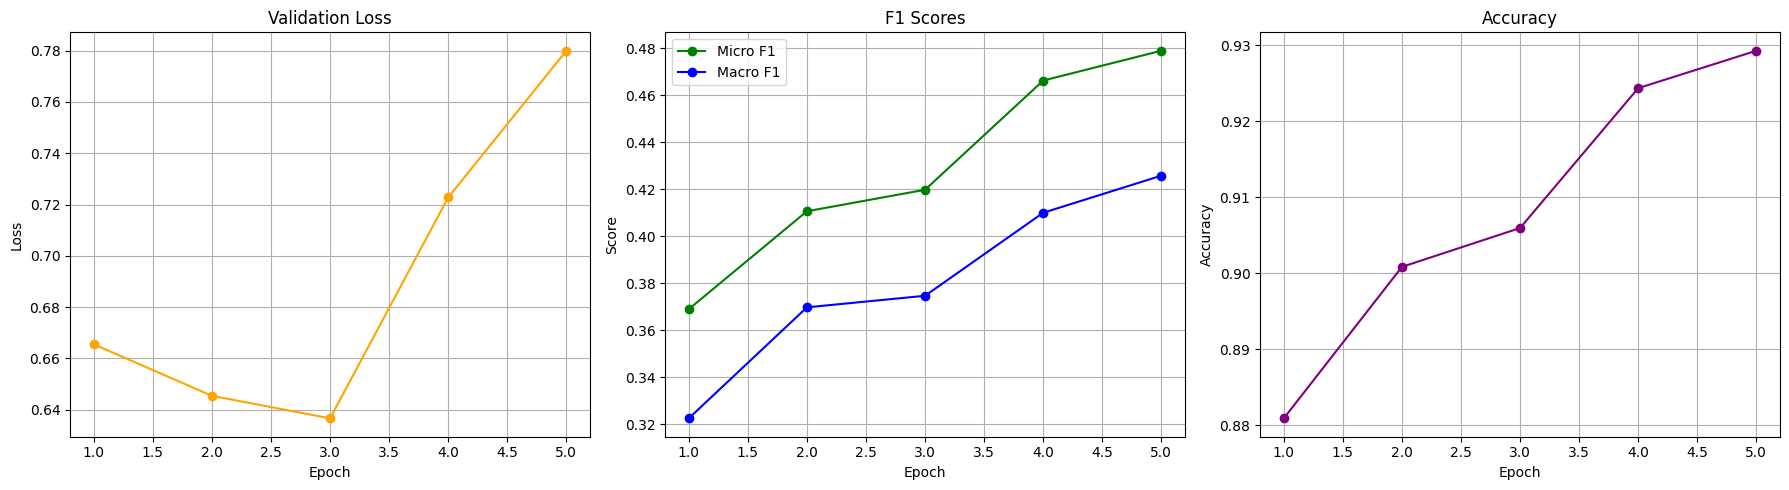

: 

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3, 4, 5]
val_loss = [0.665524, 0.645448, 0.636672, 0.722784, 0.779956]
micro_f1 = [0.369063, 0.410718, 0.419864, 0.466326, 0.479022]
macro_f1 = [0.322605, 0.369835, 0.374755, 0.410086, 0.425861]
accuracy = [0.880904, 0.900841, 0.905962, 0.924372, 0.929302]

# Create subplots (3 side-by-side)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Validation Loss
axes[0].plot(epochs, val_loss, marker='o', color='orange', label='Validation Loss')
axes[0].set_title('Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

# Plot 2: F1 Scores
axes[1].plot(epochs, micro_f1, marker='o', label='Micro F1', color='green')
axes[1].plot(epochs, macro_f1, marker='o', label='Macro F1', color='blue')
axes[1].set_title('F1 Scores')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].legend()
axes[1].grid(True)

# Plot 3: Accuracy
axes[2].plot(epochs, accuracy, marker='o', color='purple', label='Accuracy')
axes[2].set_title('Accuracy')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].grid(True)

# Final layout
plt.tight_layout()
plt.show()
